# Regression and Classification Notebook:
## Predict Remaining Useful Lifetime (RUL) of a NASA Run To Failure Dataset
<p style="margin:30px">
    <img style="display:inline" width=15% src="https://upload.wikimedia.org/wikipedia/commons/e/e5/NASA_logo.svg" alt="NASA" />
</p>

In this dataset different engines / turbofans (`engine_no`) are monitored over time. Time is given in cycles (`time_in_cycles`). After the last (=max) cycle of an engine maintenance is required.

The aim of this notebook is to predict the **Remaining Useful Life (RUL)** which can be defined as the amount of remaining cycles of an engine until maintenance is needed. Therefore different data are given for this time-series analysis:
- on the hand the `operational_settings` of each engine and
- on the other hand different sensor observations which are called `sensor_measurements` and recorded for each cycle.

The **dataset**, further information and some publications can be found in [NASA's Prognostics Center of Excellence](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan).


## Constants
- SUBWINDOW_LENGTH: Lenght of a subwindow = number of samples per subwindow
- SUBWINDOWS: Number of conherent subwindows per window

In [1]:
SUBWINDOW_LENGTH = 50
SUBWINDOWS = 50               # can be ignored if 'MAXIMIZE_SUBWINDOWS' is set on True
MAXIMIZE_SUBWINDOWS = True    # will create maximum number of subwindows out of a window

WINDOW_LENGTH = 100

#DEVICE = "cuda"
DEVICE = "cpu"


MAX_EPOCHS = 4

TARGET_CLIP_UPPER = True
TARGET_MAX = 125              # maximum RUL-value for each `unit_number`
TARGET_CLIP_LOWER = False
TARGET_MIN = 10               # minimum RUL-value for each `unit_number`

SUBWINDOW_TARGET = "min"      # Defines target within subwindow



## Import of predefined functions

In [2]:
from datetime import datetime
import math
import numpy as np
from pathlib import Path
import pickle
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import sys
import time
from tqdm import tqdm

import ipywidgets as widgets
from ipywidgets import interact, fixed

from IPython.display import clear_output

import matplotlib as mpl
mpl.rcParams['axes.formatter.use_locale'] = True
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import locale
locale.setlocale(locale.LC_ALL, 'de_DE')

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score,\
    recall_score, r2_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV

import skorch
from skorch.regressor import NeuralNetRegressor
from skorch.helper import predefined_split
from skorch.callbacks import Callback, Checkpoint, LRScheduler



##  Custom function imports
E.g. functions to save figures, change colormap

In [3]:
from plotting_lib import return_current_date_and_time, truncate_colormap, save_figure,\
    plot_correlation_heatmap, plot_samples_over_feature, plot_all_features_for_all_units,\
        plot_percentage_of_removed_cycles, plot_colorbar, plot_samples_in_test_and_rul_dataset,\
            plot_mse_and_rul_scoring_function, plot_signal_contributions_of_pcs, plot_retained_variance,\
                plot_categories_over_pc_1_and_2, plot_different_categories_for_one_feature,\
                    plot_binary_classification_over_pc_1_and_2, plot_model_results,\
                        plot_signal_contribution_for_single_pc


from data_preprocessing import subdivide_dataframe_by_feature, add_target_feature, create_coherent_windows,\
    get_subwindows_from_window, get_subwindows_from_dataframes, subdivide_indices_of_a_list,\
        normalize_feature_values, pipeline_level_0, pipeline_level_2

from regression_models import get_rul_score, HistoryPlotter, evaluate_regression_model, ConvRegressor,\
    DNNRegressor, RNNRegressor



## Import data from .txt-Files

In [4]:
FEATURES = ["operational_setting_%s" %i for i in range(1, 4)] +\
           ["sensor_measurement_%s" %i for i in range(1, 22)]

COLUMN_LABELS = ["unit_number", "time_in_cycles"] + FEATURES
SENSOR_FEATURES = COLUMN_LABELS[5:]

path_cands = [r"..\CMAPSSData",
              r".\CMAPSSData",
              r"CMAPSSData"]

path = [path for path in path_cands if Path(path).exists()][0]

INPUT_FILE_RUL = "RUL_FD001.txt"
INPUT_FILE_TRAIN = "train_FD001.txt"
INPUT_FILE_TEST = "test_FD001.txt"

'''
INPUT_FILE_RUL = "RUL_FD002.txt"
INPUT_FILE_TRAIN = "train_FD002.txt"
INPUT_FILE_TEST = "test_FD002.txt"
'''

INPUT_FILE_RUL = pd.read_csv(path + "/" + INPUT_FILE_RUL, header=None, names=["RUL_FD001"])
INPUT_FILE_RUL = INPUT_FILE_RUL["RUL_FD001"]

def from_csv(file):
    kwargs = dict(header=None, delim_whitespace=True, names=COLUMN_LABELS)
    data = pd.read_csv(file, **kwargs)
    return data

INPUT_FILE_TRAIN = from_csv(path + "/" + INPUT_FILE_TRAIN)
INPUT_FILE_TEST = from_csv(path + "/" + INPUT_FILE_TEST)



---
---
# **Classification based on principal components of the C-MAPSS Training Dataset**
---
---

## Function to add urgency label for classification to list of dataframes

In [5]:
def add_urgency_feature(dataframe,
                        target_feature_name="target",
                        urgency_indicator_name="Urgency_Indicator"):

    label_list = []
    target_series = dataframe[target_feature_name]
    for value in target_series:
        if value >= 201:
            label_list.append("Long")
        elif value >= 126:
            label_list.append("Medium")
        elif value >= 51:
            label_list.append("Short")
        else:
            label_list.append("Urgent")

    dataframe[urgency_indicator_name] = label_list

    return dataframe



In [6]:
list_of_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TRAIN)
test_df = list_of_dataframes[0].copy()
add_target_feature(test_df)
add_urgency_feature(test_df)
test_df

,unit_number,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,target,Urgency_Indicator
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191.0,Medium
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190.0,Medium
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189.0,Medium
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188.0,Medium
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187.0,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1,188,-0.0067,0.0003,100.0,518.67,643.75,1602.38,1422.78,14.62,...,8117.69,8.5207,0.03,396,2388,100.0,38.51,22.9588,4.0,Urgent
188,1,189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,14.62,...,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127,3.0,Urgent
189,1,190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,14.62,...,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675,2.0,Urgent
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,...,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295,1.0,Urgent


## PCA

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [8]:
# save sensor data in np.array for further processing
X = INPUT_FILE_TRAIN[SENSOR_FEATURES]
'''
# What happens if features are identical; Therefore add a duplicated feature series
X = pd.concat([X, INPUT_FILE_TRAIN[SENSOR_FEATURES[0]]], axis=1)
# Rename features
X.columns = pd.io.parsers.ParserBase({'names': X.columns})._maybe_dedup_names(X.columns)
# Sort features
X = X.reindex(sorted(X.columns), axis=1)

# Alternative:
#X["Sensor_duplicate"] = INPUT_FILE_TRAIN[SENSOR_FEATURES[0]]
'''


m = X.shape[0]
n = X.shape[1]

# Standardize data
scaler = StandardScaler()
Z = scaler.fit_transform(X)

# Run PCA
pca = PCA().fit(Z)
coeff = (pca.components_).T
score = pca.transform(Z)
variance_ratio = pca.explained_variance_ratio_

# fit and transform at same time
pc_array = PCA().fit_transform(Z)

assert (score[0].round(3) == pc_array[0].round(3)).all()

In [9]:
X

,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_10,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


### Further data-preprocessing

In [10]:
# Cast 'pc_array' to dataframe
PC_FEATURES = ["PC_%s" % str(x) for x in range(1, pc_array.shape[1] + 1)]
pc_df = pd.DataFrame(pc_array,
                     columns=PC_FEATURES)


list_of_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TRAIN)

for dataframe in list_of_dataframes:
    add_target_feature(dataframe)
    add_urgency_feature(dataframe)

expanded_df = pd.concat(list_of_dataframes, axis=0)

target_df = expanded_df["target"]
urgency_series = expanded_df["Urgency_Indicator"]

### Plot relevance of principal components

Figure not saved


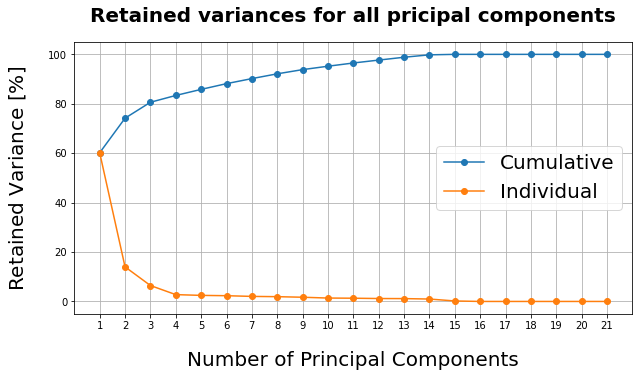

In [11]:
plot_retained_variance(variance_ratio,
                       saving_path=r".\Plots",
                       save_fig=False,
                       plot_format="png")

### Plot signal contributions to the respective principal components (for all pcs)

In [12]:
interact(plot_signal_contributions_of_pcs,
         coefficients=fixed(coeff),
         features=fixed(SENSOR_FEATURES),
         pc_numbers=widgets.IntSlider(min=1, max=21, value=2, continuous_update=False,
                                      description="Number of principal components"),
         space_between_pcs=widgets.IntSlider(min=1, max=10, value=5, continuous_update=False,
                                            description="Space between bars"));

interactive(children=(IntSlider(value=2, continuous_update=False, description='Number of principal components'…

### Plot signal contributions to the respective principal components (for each single pc separately)

In [13]:
#%matplotlib inline

interact(plot_signal_contribution_for_single_pc,
         coefficients=fixed(coeff),
         features=fixed(SENSOR_FEATURES),
         pc_numbers=widgets.IntSlider(min=1, max=21, value=2, continuous_update=False,
                                      description="Number of principal components"),
         space_between_pcs=widgets.IntSlider(min=1, max=10, value=5, continuous_update=False,
                                            description="Space between bars"));


interactive(children=(IntSlider(value=2, continuous_update=False, description='Number of principal components'…

### Plot 'Urgency_Indicator' over first two principal components
Result: indicators 'Long' and 'Medium' are limited to single spots, whereas all other indicators are forming a line ("glazing")

Figure not saved


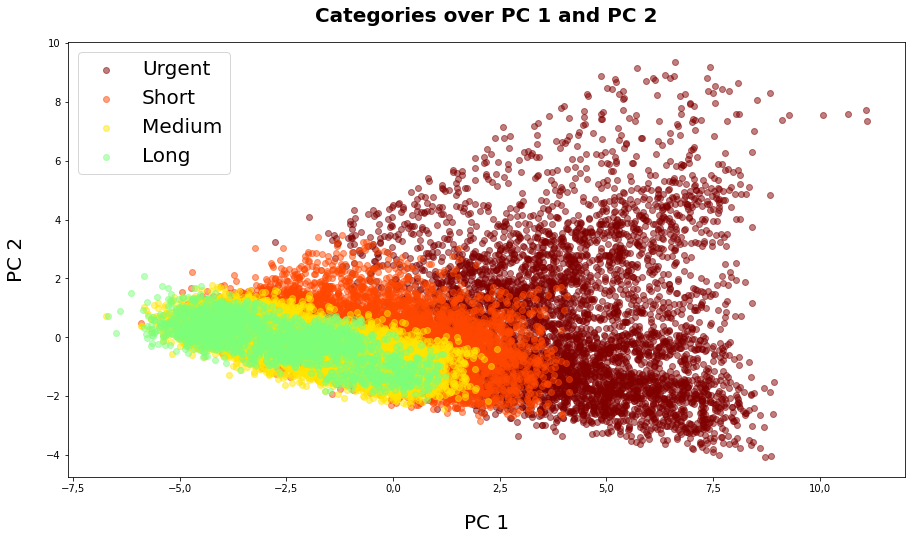

In [14]:
urgency_indicators = ["Long", "Medium", "Short", "Urgent"]

plot_categories_over_pc_1_and_2(principal_component_df=pc_df,
                                urgency_indicators=urgency_indicators,
                                urgency_series=urgency_series,
                                saving_path=r".\Plots",
                                save_fig=False,
                                plot_format="png")

### 3D Plot: 'Urgency_Indicator' over first two principal components together with operational settings
In the following the influence of the three features `operational_setting_1`, `operational_setting_2` and `operational_setting_3` is  investigated: In case that agglomerations of samples of a specific operational setting can be found in the PC1-PC2-plane, further preprocessing steps are necessary. As an example high values of the first principal component could be characteristic for the category "urgent", but only for `operational_setting_1` and `operational_setting_2`.

Thus a filtering procedure is shown in the graphic below through different markers. Those represent the dataset filtered for a single operational setting.
Values for the operational settings are shown along the z-axis over the PC1-PC2-plane. The values of `operational_setting_1` and `operational_setting_2` are coherent, whereas values of `operational_setting_3` show an offset along the setting values. Since this offset is not in the PC1-PC2-plane, the operational settings have no influence on the first two principal components and further preprocessing steps are not necessary.

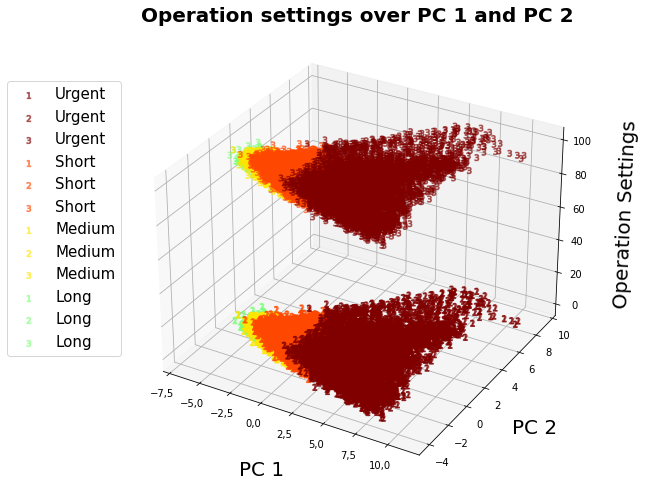

In [15]:
#%matplotlib notebook

FONTSIZE = 20
PAD = 20

urgency_indicators = ["Long", "Medium", "Short", "Urgent"]


norm = mpl.colors.Normalize(vmin=0,
                            vmax=len(urgency_indicators) - 1)

# Take only colors from green to red. Therefore start in mid of colormap
cmap = truncate_colormap(cmap=plt.cm.jet,
                         minimum=0.5)

plt.figure(figsize =(10, 10))
axis = plt.subplot(projection="3d")


markers = ["$1$", "$2$", "$3$"] #["$\\alpha$", "$\\beta$", "$\gamma$"]

# Start with 'urgent', since scatters are overlaying
for index, indicator in enumerate(urgency_indicators[::-1]):
    sub_df = pc_df[urgency_series == indicator]
    x_values = sub_df["PC_1"]
    y_values = sub_df["PC_2"]
    for marker, setting in zip(markers, range(1, 4)):
        operational_setting = "operational_setting_" + str(setting)
        z_values = expanded_df[operational_setting][urgency_series == indicator]
        axis.scatter(x_values, y_values, z_values,
                     label=indicator, cmap=cmap, marker=marker,
                     color=cmap(norm(urgency_indicators.index(indicator))),
                     alpha=0.5,
                     s=40)

axis.legend(bbox_to_anchor=(0, 0.9), fontsize=15)

# Adjust labels
axis.set_xlabel("PC 1", fontsize=FONTSIZE, labelpad=PAD)
axis.set_ylabel("PC 2", fontsize=FONTSIZE, labelpad=PAD)
axis.set_zlabel("Operation Settings", fontsize=FONTSIZE, labelpad=PAD)
axis.set_title("Operation settings over PC 1 and PC 2",
               weight="bold", fontsize=FONTSIZE)


plt.tight_layout(pad=5)
save_figure(saving_path=r".\Plots",
            figure_name="Operational_settings_over_pc_1_and_2",
            save_fig=True,
            plot_format="pdf")



### Plot different categories

Figure not saved


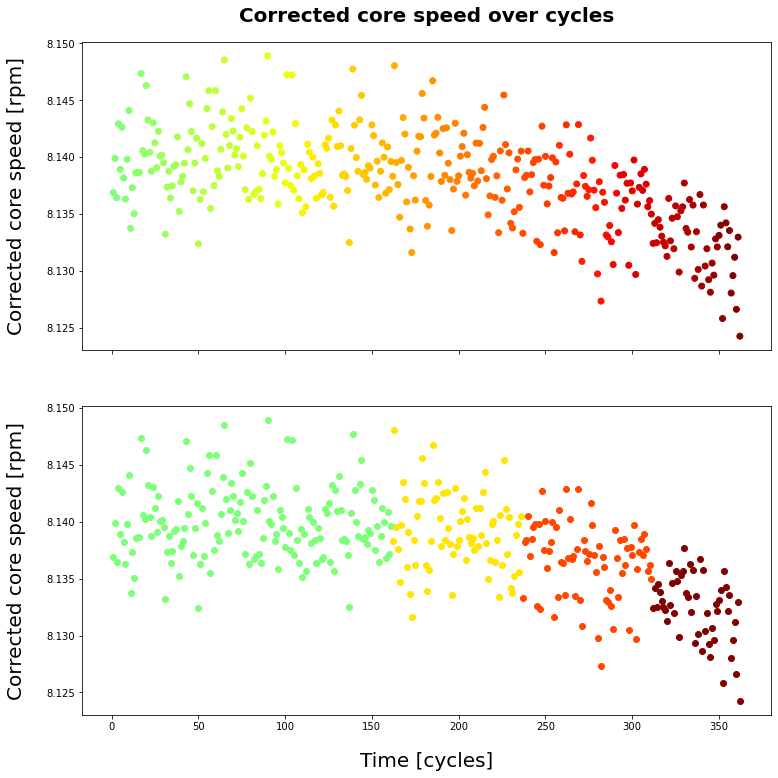

In [16]:
list_of_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TRAIN)

for dataframe in list_of_dataframes:
    add_target_feature(dataframe)
    add_urgency_feature(dataframe)

plot_different_categories_for_one_feature(selected_df=list_of_dataframes[68],
                                          feature="sensor_measurement_14",
                                          urgency_indicators=urgency_indicators,
                                          regression_feature="time_in_cycles",
                                          saving_path=r".\Plots",
                                          save_fig=False,
                                          plot_format="pdf")

### 3D Plot for first 3 principal components

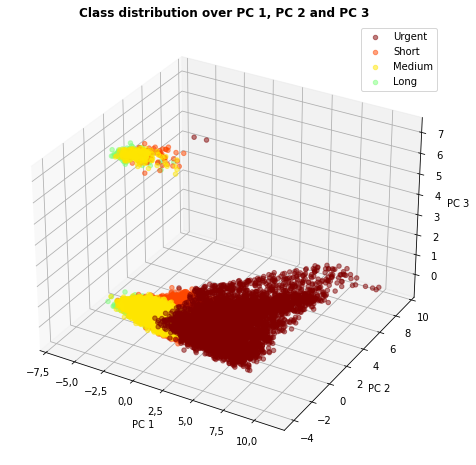

In [17]:
#%matplotlib notebook
#from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline

plt.figure(figsize =(15, 8))
axis = plt.subplot(projection="3d")

urgency_indicators = ["Long", "Medium", "Short", "Urgent"]

norm = mpl.colors.Normalize(vmin=0,
                            vmax=len(urgency_indicators) - 1)

# Take only colors from green to red. Therefore start in mid of colormap
cmap = truncate_colormap(cmap=plt.cm.jet,
                         minimum=0.5)

# Start with 'urgent', since scatters are overlaying
for index, indicator in enumerate(urgency_indicators[::-1]):
    sub_df = pc_df[urgency_series == indicator]
    axis.scatter(sub_df["PC_1"], sub_df["PC_2"], sub_df["PC_3"], label=indicator,
                 color=cmap(norm(urgency_indicators.index(indicator))), alpha=0.5)

# Adjust labels
axis.set_xlabel("PC 1")
axis.set_ylabel("PC 2")
axis.set_zlabel("PC 3")
axis.set_title("Class distribution over PC 1, PC 2 and PC 3", weight="bold")
axis.legend();

## Binary classification

In the following a binary classification based on the first two principal componentents is realised.
The two categories which shall be predicted are "urgent" with less than 50 remaining cycles and the complementary category "not urgent" with more or equal than 50 remaining cycles.

### Plot two categories over first two principal components

Figure not saved


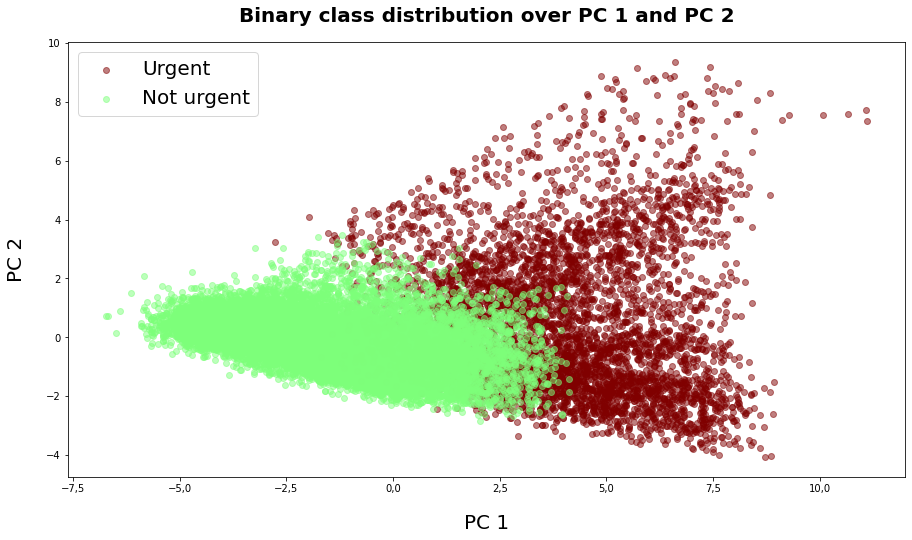

In [18]:
#%matplotlib inline
plot_binary_classification_over_pc_1_and_2(principal_component_df=pc_df,
                                           urgency_series=urgency_series,
                                           saving_path=r".\Plots",
                                           save_fig=False,
                                           plot_format="png")

### 3D Plot for first 2 principal components and operational settings

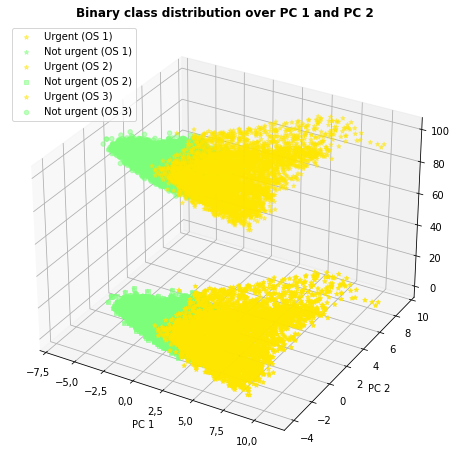

In [19]:
plt.figure(figsize =(15, 8))
axis = plt.subplot(projection="3d")

# Start with 'urgent', since scatters are overlaying
is_urgent = urgency_series == "Urgent"

# operation_setting_series
os_1_series = INPUT_FILE_TRAIN["operational_setting_1"]
os_2_series = INPUT_FILE_TRAIN["operational_setting_2"]
os_3_series = INPUT_FILE_TRAIN["operational_setting_3"]

axis.scatter(pc_df[is_urgent]["PC_1"], pc_df[is_urgent]["PC_2"], os_1_series[is_urgent],
             label="Urgent (OS 1)", color=cmap(norm(1)), alpha=0.5, marker="*")
axis.scatter(pc_df[~is_urgent]["PC_1"], pc_df[~is_urgent]["PC_2"], os_1_series[~is_urgent],
             label="Not urgent (OS 1)", color=cmap(norm(0)), alpha=0.5, marker="*")

axis.scatter(pc_df[is_urgent]["PC_1"], pc_df[is_urgent]["PC_2"], os_2_series[is_urgent],
             label="Urgent (OS 2)", color=cmap(norm(1)), alpha=0.5, marker="*")
axis.scatter(pc_df[~is_urgent]["PC_1"], pc_df[~is_urgent]["PC_2"], os_2_series[~is_urgent],
             label="Not urgent (OS 2)", color=cmap(norm(0)), alpha=0.5, marker="s")

axis.scatter(pc_df[is_urgent]["PC_1"], pc_df[is_urgent]["PC_2"], os_3_series[is_urgent],
             label="Urgent (OS 3)", color=cmap(norm(1)), alpha=0.5, marker="*")
axis.scatter(pc_df[~is_urgent]["PC_1"], pc_df[~is_urgent]["PC_2"], os_3_series[~is_urgent],
             label="Not urgent (OS 3)", color=cmap(norm(0)), alpha=0.5, marker="o")


# Adjust labels
axis.set_xlabel("PC 1")
axis.set_ylabel("PC 2")
axis.set_title("Binary class distribution over PC 1 and PC 2", weight="bold")
axis.legend();

### Logistic Regression; training based on specified prinicipal components

In [20]:
PC_NUMBERS = 2

In [21]:
from sklearn.linear_model import LogisticRegression


X_train = pc_df.values[:, :PC_NUMBERS]
y_train = (urgency_series.values == "Urgent").astype("int")


clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)

print("Logistic regression stats on train dataset:")
print("F1-Score:\t" + "{:.4f}".format(f1))
print("Accuracy:\t" + "{:.2f}".format(100 * accuracy) + " %")
print('Precision:\t' + "{:.4f}".format(precision))
print('Recall:\t\t' + "{:.4f}".format(recall))
print("Confusion matrix:\n", confusion_matrix(y_train, y_pred))

Logistic regression stats on train dataset:
F1-Score:	0.8502
Accuracy:	92.88 %
Precision:	0.8855
Recall:		0.8176
Confusion matrix:
 [[14992   539]
 [  930  4170]]


#### Fault Analysis: Plot falsely / correctly predicted categories

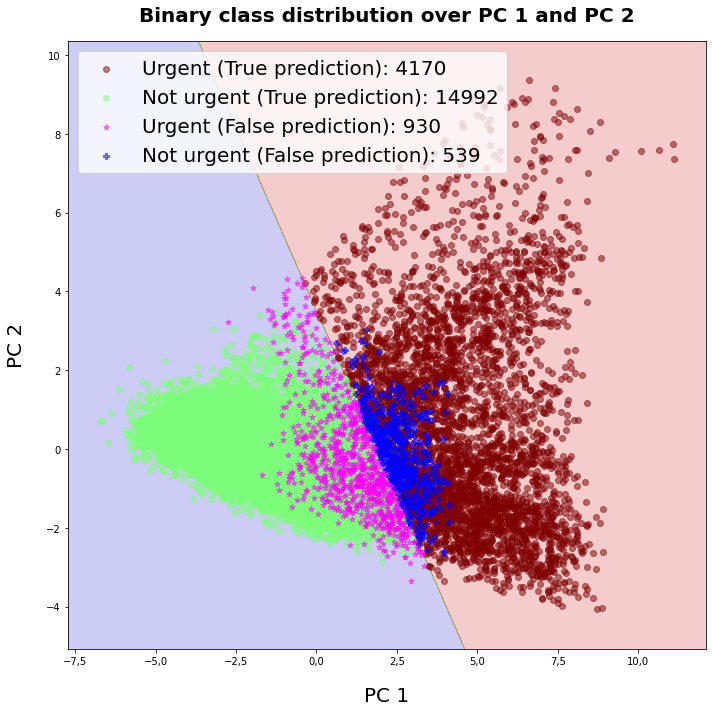

In [22]:
plot_model_results(principal_component_df=pc_df,
                   urgency_series=urgency_series,
                   X_train=X_train,
                   y_train=y_train,
                   y_pred=y_pred,
                   model=clf,
                   saving_path=r".\Plots",
                   save_fig=True,
                   plot_format="pdf")

### Small Neural Network

In [23]:
from sklearn.neural_network import MLPClassifier

mlp_small = MLPClassifier(hidden_layer_sizes=(10, 5),
                          activation="relu", solver="adam", max_iter=200,
                          verbose=True)

mlp_small.fit(X_train, y_train)

y_pred = mlp_small.predict(X_train)


accuracy = accuracy_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)

print("Neural network stats on train dataset:")
print("F1-Score:\t" + "{:.4f}".format(f1))
print("Accuracy:\t" + "{:.2f}".format(100 * accuracy) + " %")
print('Precision:\t' + "{:.4f}".format(precision))
print('Recall:\t\t' + "{:.4f}".format(recall))
print("Confusion matrix:\n", confusion_matrix(y_train, y_pred))

Iteration 1, loss = 0.45535612
Iteration 2, loss = 0.28748862
Iteration 3, loss = 0.21527486
Iteration 4, loss = 0.18625718
Iteration 5, loss = 0.17442562
Iteration 6, loss = 0.16847998
Iteration 7, loss = 0.16551976
Iteration 8, loss = 0.16366445
Iteration 9, loss = 0.16265987
Iteration 10, loss = 0.16208005
Iteration 11, loss = 0.16173242
Iteration 12, loss = 0.16147663
Iteration 13, loss = 0.16111823
Iteration 14, loss = 0.16088057
Iteration 15, loss = 0.16069752
Iteration 16, loss = 0.16074632
Iteration 17, loss = 0.16064488
Iteration 18, loss = 0.16032807
Iteration 19, loss = 0.16025814
Iteration 20, loss = 0.16043661
Iteration 21, loss = 0.16004183
Iteration 22, loss = 0.15998519
Iteration 23, loss = 0.16001635
Iteration 24, loss = 0.15988915
Iteration 25, loss = 0.15985974
Iteration 26, loss = 0.15971302
Iteration 27, loss = 0.15986470
Iteration 28, loss = 0.15968312
Iteration 29, loss = 0.15965274
Iteration 30, loss = 0.15959199
Iteration 31, loss = 0.15956740
Iteration 32, los

#### Fault Analysis: Plot falsely / correctly predicted categories

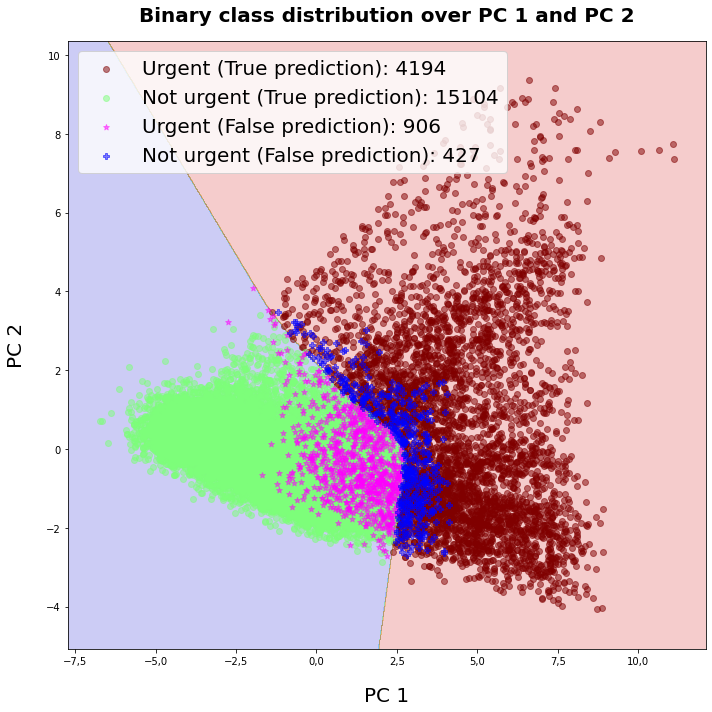

In [24]:
plot_model_results(principal_component_df=pc_df,
                   urgency_series=urgency_series,
                   X_train=X_train,
                   y_train=y_train,
                   y_pred=y_pred,
                   model=mlp_small,
                   saving_path=r".\Plots",
                   save_fig=True,
                   plot_format="pdf")

### Large Neural Network

In [25]:
mlp_large = MLPClassifier(hidden_layer_sizes=(40, 30, 20),
                          activation="relu", solver="adam", max_iter=200,
                          verbose=True)

mlp_large.fit(X_train, y_train)

y_pred = mlp_large.predict(X_train)


accuracy = accuracy_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)

print("Neural network stats on train dataset:")
print("F1-Score:\t" + "{:.4f}".format(f1))
print("Accuracy:\t" + "{:.2f}".format(100 * accuracy) + " %")
print('Precision:\t' + "{:.4f}".format(precision))
print('Recall:\t\t' + "{:.4f}".format(recall))
print("Confusion matrix:\n", confusion_matrix(y_train, y_pred))

Iteration 1, loss = 0.34634667
Iteration 2, loss = 0.16546134
Iteration 3, loss = 0.16139234
Iteration 4, loss = 0.16009756
Iteration 5, loss = 0.15974875
Iteration 6, loss = 0.15929127
Iteration 7, loss = 0.15924182
Iteration 8, loss = 0.15868584
Iteration 9, loss = 0.15894924
Iteration 10, loss = 0.15895214
Iteration 11, loss = 0.15931380
Iteration 12, loss = 0.15817819
Iteration 13, loss = 0.15881105
Iteration 14, loss = 0.15831546
Iteration 15, loss = 0.15806259
Iteration 16, loss = 0.15797393
Iteration 17, loss = 0.15794244
Iteration 18, loss = 0.15811649
Iteration 19, loss = 0.15760034
Iteration 20, loss = 0.15802522
Iteration 21, loss = 0.15818614
Iteration 22, loss = 0.15762024
Iteration 23, loss = 0.15790636
Iteration 24, loss = 0.15723000
Iteration 25, loss = 0.15720767
Iteration 26, loss = 0.15720372
Iteration 27, loss = 0.15707433
Iteration 28, loss = 0.15706058
Iteration 29, loss = 0.15720406
Iteration 30, loss = 0.15691687
Iteration 31, loss = 0.15683232
Iteration 32, los

#### Fault Analysis: Plot falsely / correctly predicted categories

Figure not saved


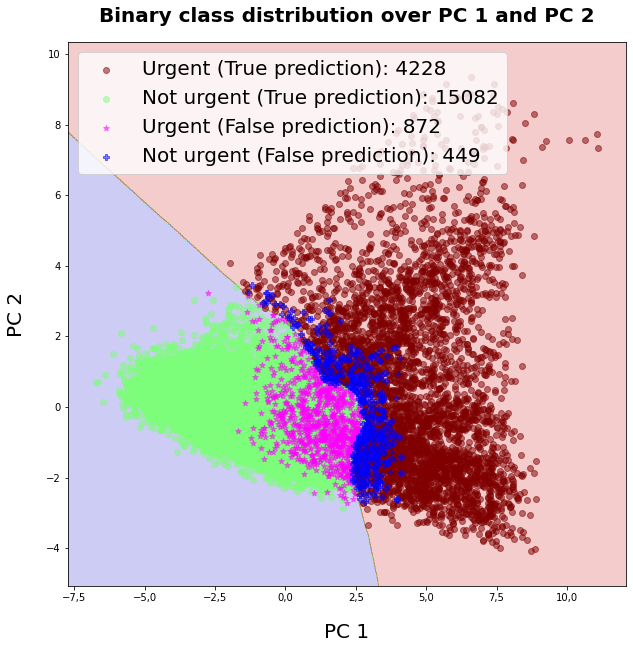

In [26]:
plot_model_results(principal_component_df=pc_df,
                   urgency_series=urgency_series,
                   X_train=X_train,
                   y_train=y_train,
                   y_pred=y_pred,
                   model=mlp_large,
                   saving_path=r".\Plots",
                   save_fig=False,
                   plot_format="pdf")

## Model validation on new data

### Add remaining useful lifetime (RUL) to remaining cycles in test-data

In [27]:
list_of_test_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TEST)

for test_df, RUL in zip(list_of_test_dataframes, INPUT_FILE_RUL):
    add_target_feature(test_df)
    test_df["target"] = test_df["target"] + RUL
    if TARGET_CLIP_UPPER:
      test_df["target"] = test_df["target"].clip(upper=TARGET_MAX)
    add_urgency_feature(test_df)

test_data = pd.concat(list_of_test_dataframes, axis=0)
test_urgency_series = test_data["Urgency_Indicator"]

In [28]:
test_data;

In [29]:
# Take only sensor features
test_sensor_data = test_data[SENSOR_FEATURES]

# Standardize data
Z_test = scaler.transform(test_sensor_data)

# fit and transform at same time
pc_test_array = PCA().fit_transform(Z_test)

# Cast 'pc_test_array' to dataframe
pc_test_df = pd.DataFrame(pc_test_array,
                          columns=["PC_%s" % str(x) for x in range(1, pc_test_array.shape[1] + 1)])

In [30]:
X_test = pc_test_df.values[:, :PC_NUMBERS]
y_test = (test_urgency_series.values == "Urgent").astype("int")

### Logistic Regression model on test-data

In [31]:
y_test_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)

print("Logistic regression stats on test dataset:")
print("F1-Score:\t" + "{:.4f}".format(f1))
print("Accuracy:\t" + "{:.2f}".format(100 * accuracy) + " %")
print('Precision:\t' + "{:.4f}".format(precision))
print('Recall:\t\t' + "{:.4f}".format(recall))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))

Logistic regression stats on test dataset:
F1-Score:	0.4437
Accuracy:	85.77 %
Precision:	0.3017
Recall:		0.8386
Confusion matrix:
 [[10490  1720]
 [  143   743]]


### Small Neural network model on test-data

In [32]:
y_test_pred = mlp_small.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)

print("Small Neural network stats on test dataset:")
print("F1-Score:\t" + "{:.4f}".format(f1))
print("Accuracy:\t" + "{:.2f}".format(100 * accuracy) + " %")
print('Precision:\t' + "{:.4f}".format(precision))
print('Recall:\t\t' + "{:.4f}".format(recall))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))

Small Neural network stats on test dataset:
F1-Score:	0.5300
Accuracy:	91.16 %
Precision:	0.4138
Recall:		0.7370
Confusion matrix:
 [[11285   925]
 [  233   653]]


### Large Neural network model on test-data

In [33]:
y_test_pred = mlp_large.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)

print("Large Neural network stats on test dataset:")
print("F1-Score:\t" + "{:.4f}".format(f1))
print("Accuracy:\t" + "{:.2f}".format(100 * accuracy) + " %")
print('Precision:\t' + "{:.4f}".format(precision))
print('Recall:\t\t' + "{:.4f}".format(recall))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))

Large Neural network stats on test dataset:
F1-Score:	0.5041
Accuracy:	90.23 %
Precision:	0.3839
Recall:		0.7336
Confusion matrix:
 [[11167  1043]
 [  236   650]]


### Influence of random seed
Even if a random seed is set into a function, another constant seed is set globally.

This won't change if seed is not set to None.

In [34]:
import numpy as np


#np.random.seed(None)

test_list = list(range(100))


def print_func():
    np.random.seed(42)
    print(np.random.choice(test_list,
                           size=5,
                           replace=False))
    np.random.seed(None)


print_func()

print(np.random.choice(test_list,
                       size=5,
                       replace=False))

print(np.random.choice(test_list,
                       size=5,
                       replace=False))

[83 53 70 45 44]
[65 68 16 63 70]
[99 68  4 97 50]
